In [1]:
# !pip install csrgraph

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import load_dataset, create_graph_from_dataframe, fit_and_evaluate, grid_search_embedding_size
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# انتخاب مجموعه داده
dataset_name = "CA"   # یا "MHD"
embedding_sizes = [2,5] # [8, 16, 32, 64]


In [3]:
df, numeric_features, threshold = load_dataset(dataset_name)
G = create_graph_from_dataframe(df, numeric_features, threshold)

print(f"Dataset {dataset_name}: {df.shape[0]} samples, {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
df.head()


Building graph: 100%|██████████| 534477/534477 [00:12<00:00, 43110.28it/s]


Dataset CA: 20433 samples, 20433 nodes, 534477 edges


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,price,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,id
0,-122.23,37.88,0.982163,-0.803813,-0.970325,-0.973320,-0.976833,2.345163,452600,False,False,True,False,0
1,-122.22,37.86,-0.606210,2.042130,1.348276,0.861339,1.670373,2.332632,358500,False,False,True,False,1
2,-122.24,37.85,1.855769,-0.535189,-0.825561,-0.819769,-0.843427,1.782939,352100,False,False,True,False,2
3,-122.25,37.85,1.855769,-0.623510,-0.718768,-0.765056,-0.733562,0.932970,341300,False,False,True,False,3
4,-122.25,37.85,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,342200,False,False,True,False,4


In [4]:
X_base = df.drop(['price', 'id'], axis=1)
y = df['price']
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base, y, test_size=0.1, random_state=42)

results = []
for model_name, model in [
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestRegressor(random_state=42)),
]:
    metrics = fit_and_evaluate(model, X_train_base, y_train, X_test_base, y_test, verbose=True)
    results.append([f"{model_name} (Raw)", *metrics])


R2: 0.787, MAPE: 0.211, RMSE: 54214.653, Acc: 0.607
R2: 0.662, MAPE: 0.287, RMSE: 68215.591, Acc: 0.473
R2: 0.838, MAPE: 0.166, RMSE: 47200.554, Acc: 0.727


In [5]:
best_dw_size, X_dw, y_dw, dw_results = grid_search_embedding_size(df, G, embedding_sizes, method="deepwalk", dataset_name=dataset_name)
dw_results

[deepwalk] Evaluating embedding size: 2


DeepWalk Nodes: 100%|██████████| 20433/20433 [10:07<00:00, 33.66it/s] 


[deepwalk] Evaluating embedding size: 5


DeepWalk Nodes: 100%|██████████| 20433/20433 [10:21<00:00, 32.86it/s] 


[deepwalk] Best embedding size: 5 with rmse: 47738.577


,Embedding Size,rmse
0,2,47750.951926
1,5,47738.576709


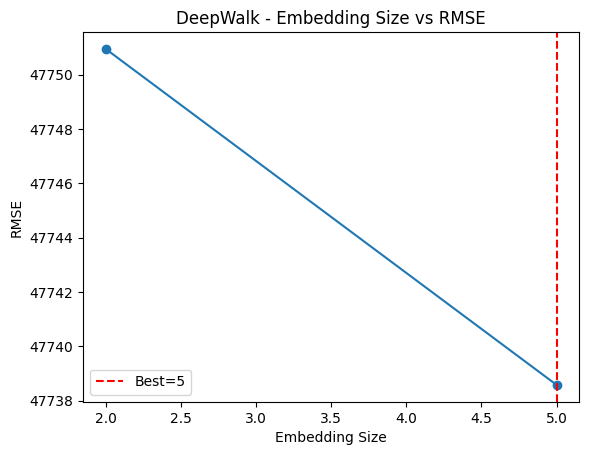

In [6]:
plt.plot(dw_results["Embedding Size"], dw_results["rmse"], marker="o")
plt.axvline(best_dw_size, color="r", linestyle="--", label=f"Best={best_dw_size}")
plt.title("DeepWalk - Embedding Size vs RMSE")
plt.xlabel("Embedding Size")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [7]:
best_n2v_size, X_n2v, y_n2v, n2v_results = grid_search_embedding_size(df, G, embedding_sizes, method="node2vec", dataset_name=dataset_name)
n2v_results

[node2vec] Evaluating embedding size: 2


Node2Vec Walks: 100%|██████████| 80/80 [02:14<00:00,  1.68s/it]


[node2vec] Evaluating embedding size: 5


Node2Vec Walks: 100%|██████████| 80/80 [01:47<00:00,  1.34s/it]


[node2vec] Best embedding size: 5 with rmse: 47299.717


,Embedding Size,rmse
0,2,47923.417361
1,5,47299.716566


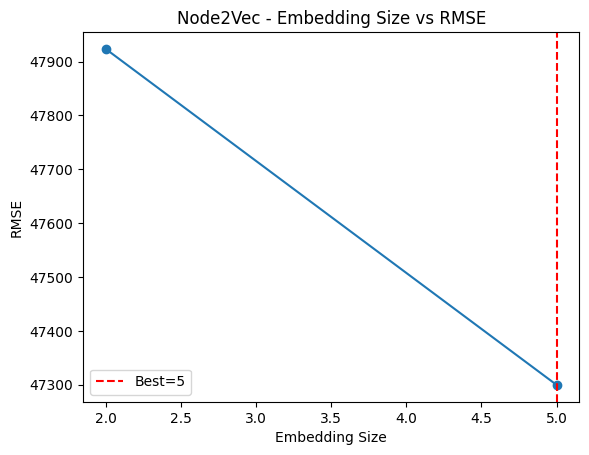

In [8]:
plt.plot(n2v_results["Embedding Size"], n2v_results["rmse"], marker="o")
plt.axvline(best_n2v_size, color="r", linestyle="--", label=f"Best={best_n2v_size}")
plt.title("Node2Vec - Embedding Size vs RMSE")
plt.xlabel("Embedding Size")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [9]:
for (label, X, y) in [
    (f"DeepWalk-{best_dw_size}", X_dw, y_dw),
    (f"Node2Vec-{best_n2v_size}", X_n2v, y_n2v),
]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    for model_name, model in [
        ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
        ("LinearRegression", LinearRegression()),
        ("RandomForest", RandomForestRegressor(random_state=42)),
    ]:
        metrics = fit_and_evaluate(model, X_train, y_train, X_test, y_test, verbose=True)
        results.append([f"{model_name} ({label})", *metrics])

R2: 0.786, MAPE: 0.213, RMSE: 54252.895, Acc: 0.607
R2: 0.669, MAPE: 0.286, RMSE: 67538.333, Acc: 0.475
R2: 0.839, MAPE: 0.167, RMSE: 47106.504, Acc: 0.735
R2: 0.794, MAPE: 0.208, RMSE: 53351.995, Acc: 0.614
R2: 0.668, MAPE: 0.287, RMSE: 67662.966, Acc: 0.473
R2: 0.848, MAPE: 0.163, RMSE: 45809.797, Acc: 0.739


In [10]:
results_df = pd.DataFrame(results, columns=["Model", "R2", "MAPE", "Accuracy", "RMSE", "MSE_log"])
results_df
results_df.to_excel(f"results/{dataset_name}/final_results_notebook.xlsx", index=False)
